In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/youtube_sentiment_analysis/sentiment_tokens.xlsx')

### loading the Tokenized comments excel file

In [ ]:
df.columns

Index(['Sentiment', 'tokens'], dtype='object')

In [ ]:
df['tokens'].value_counts()

,count
tokens,
['red_heart'],1233
['thank'],858
"['thank', 'you']",768
[],677
"['thank', '!']",579
...,...
"['fact', '’', 'promotion', 'arcane', 'sequel', 'series', 'wild', 'would', 'absolutely', 'watch', 'make', 'one']",1
"['weve', 'empty', 'load']",1
"['good', 'go', 'take', 'job', 'home', '’', 'belong', '!']",1


In [ ]:
len(df['tokens'])

963055

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963055 entries, 0 to 963054
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Sentiment  963055 non-null  object
 1   tokens     963055 non-null  object
dtypes: object(2)
memory usage: 14.7+ MB


#### Check length of token lists:

In [ ]:
# 2. Check length of token lists:

In [ ]:
df['token_len'] = df['tokens'].apply(len)
df['token_len'].describe()

,token_len
count,963055.000000
mean,121.942904
std,191.258445
min,2.000000
25%,46.000000
50%,80.000000
75%,139.000000
max,32767.000000


In [ ]:
df.sample(3)

,Sentiment,tokens,token_len
75239,Positive,"['im', 'autistic', 'rly', 'appreciate', 'present', 'get', 'js', 'cant', 'process', 'things', 'fast', 'enough', 'show', 'immediately']",133
45230,Neutral,"['you', 'create', 'tutorial', 'django', '?']",44
47889,Neutral,"['guideline', 'number', 'one', ':', 'master', 'never', 'overshadow']",68


In [ ]:
print(type(df['tokens'].iloc[0]))


<class 'str'>


In [ ]:
len("['hello', 'world']")  # = 21 (counting characters)
# len(['hello', 'world'])    # = 2  (correct!)


18

##### Step 1: Convert strings to real lists (again)

In [ ]:
import ast

def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []  # or np.nan, or None
    return x

df['tokens'] = df['tokens'].apply(safe_literal_eval)


In [ ]:
df['token_len'] = df['tokens'].apply(len)

In [ ]:
df['token_len'].describe()

,token_len
count,963055.000000
mean,12.664292
std,18.389903
min,0.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,1532.000000


In [ ]:
df.sample(4)

,Sentiment,tokens,token_len
710319,Neutral,"[kuka, crazy, face_with_tears_of_joy, face_with_tears_of_joy, face_with_tears_of_joy, face_with_tears_of_joy]",6
160159,Neutral,"[drake, ?]",2
722386,Positive,"[send, prayers, volunteer, fire, fighters, also, must, hard]",8
453020,Negative,"[update, original, list, ?, like, want, print, old, listdirectly, update, list, function, ?]",13


##### Step 2:Find rows with empty tokens:

In [ ]:
# 3. Find rows with empty tokens:
df[df['tokens'].apply(lambda x: len(x) == 0)]


,Sentiment,tokens,token_len
922,Neutral,[],0
2017,Neutral,[],0
3498,Neutral,[],0
7859,Neutral,[],0
9812,Neutral,[],0
...,...,...,...
952242,Neutral,[],0
953747,Neutral,[],0
954710,Neutral,[],0
954816,Neutral,[],0


In [ ]:
df = df[df['tokens'].apply(lambda x: len(x) > 0)]

In [ ]:
df.shape

(962376, 3)

##### Step 3:Visualize top phrases:

In [ ]:
# 4. Visualize top phrases:
df['tokens'].value_counts().head(10).plot(kind='barh')


### new_Word2Vec model with 200 dimensions

In [ ]:
import torch

if torch.cuda.is_available():
    print("✅ GPU is available:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not found, using CPU.")


✅ GPU is available: Tesla T4


In [ ]:
!pip install -U gensim

In [ ]:
!pip install numpy==1.23.5 --force-reinstall


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
cvxpy 1.6.5 requ

In [ ]:
import gensim
from gensim.models import Word2Vec

print("Gensim version:", gensim.__version__)

Gensim version: 4.3.3


In [ ]:
import numpy as np
print("Numpy version:", np.__version__)

Numpy version: 1.23.5


### Model_creation_word2vec_200_dim

In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
w2v_model2 = Word2Vec(
    sentences=df['tokens'].tolist(),  # List of tokenized comments
    vector_size=200,                  # Size of word vectors (can try 100–300)
    window=5,                         # Context window size (based on your token stats)
    min_count=5,                      # Ignore words with total frequency < 5
    sg=1,                             # Use Skip-Gram (sg=1); CBOW if sg=0
    workers=4,                        # Number of parallel threads
    epochs=10                         # Number of passes over the data
)


In [ ]:
# Save
w2v_model2.save("youtube_word2vec_200dimensional.model")

In [ ]:
print(f"Vocab size: {len(w2v_model2.wv)}")
print("Sample words:", list(w2v_model2.wv.index_to_key[:20]))


Vocab size: 45614
Sample words: ['you', 'num', '!', '?', ':', 'face_with_tears_of_joy', 'not', '’', 'red_heart', 'but', 'your', 'like', 'get', 'thank', 'make', 'people', 'go', 'one', 'use', 'video']


### Testing the youtube_word2vec_200dimensional.model

In [ ]:
w2v_model2.wv.most_similar('happy', topn=10)

[('belated', 0.6862353682518005),
 ('dejan', 0.6361109614372253),
 ('glad', 0.6345149278640747),
 ('lalande', 0.6302043199539185),
 ('colie', 0.6269300580024719),
 ('bexley', 0.6193896532058716),
 ('simji', 0.6158183217048645),
 ('chrissy', 0.6156002879142761),
 ('bex', 0.6134281158447266),
 ('excite', 0.6130989193916321)]

In [ ]:
'happy' in w2v_model2.wv

True

In [ ]:
vec = w2v_model2.wv['you']
print(vec.shape)  # Should be (200,) if vector_size=200

(200,)


#### Plot1

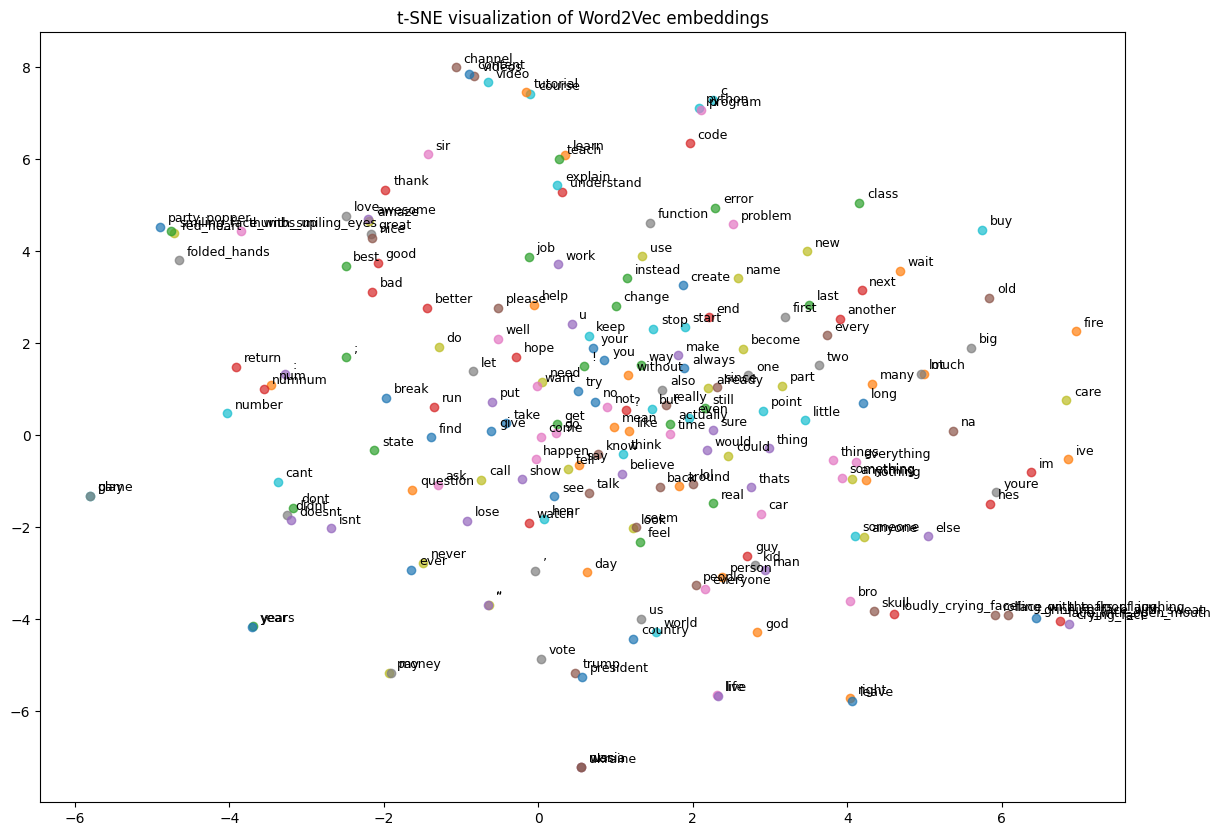

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Top 200 frequent words
words = list(w2v_model2.wv.index_to_key[:200])
word_vectors = np.array([w2v_model2.wv[w] for w in words])  # ← FIXED

# t-SNE reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vec_2d = tsne.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(14, 10))
for i, word in enumerate(words):
    plt.scatter(*word_vec_2d[i], alpha=0.7)
    plt.text(word_vec_2d[i, 0]+0.1, word_vec_2d[i, 1]+0.1, word, fontsize=9)
plt.title("t-SNE visualization of Word2Vec embeddings")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

# 1. Select vocabulary (say top 5000 frequent words)
vocab_size = 5000
words = w2v_model2.wv.index_to_key[:vocab_size]
word_vectors = np.array([w2v_model2.wv[word] for word in words])

# 2. Define number of clusters (tune this based on trial or elbow method)
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(word_vectors)

# 3. Assign each word to a cluster
labels = kmeans.labels_

# 4. Find top 10 closest words to each cluster centroid
cluster_top_words = {}

for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    cluster_words = [words[idx] for idx in cluster_indices]
    cluster_vecs = word_vectors[cluster_indices]

    # Distance to centroid
    centroid = kmeans.cluster_centers_[i]
    distances = cdist(cluster_vecs, centroid.reshape(1, -1), metric='euclidean').reshape(-1)

    # Top 10 closest words
    top10_idx = np.argsort(distances)[:10]
    top_words = [cluster_words[idx] for idx in top10_idx]
    cluster_top_words[f'Cluster {i}'] = top_words

# 5. Print top words per cluster
for cluster, top_words in cluster_top_words.items():
    print(f"\n{cluster}:")
    print(", ".join(top_words))



Cluster 0:
red_heart, two_hearts, smiling_face_with_smiling_eyes, thumbs_up, hundred_points, heart_hands, ok_hand, raising_hands, folded_hands, heart_suit

Cluster 1:
usa, country, europe, russia, countries, america, nation, russians, ukraine, putin

Cluster 2:
use, num, otherwise, btw, show, first, example, work, point, second

Cluster 3:
others, amaze, truly, love, person, wonderful, great, life, may, incredible

Cluster 4:
code, suggestions, update, errors, modify, vscode, function, method, setup, configure

Cluster 5:
lol, guy, damn, dude, lmao, haha, fuck, crazy, yeah, kid

Cluster 6:
government, situation, refuse, criminal, arrest, law, state, report, children, staff

Cluster 7:
video, learn, understand, study, topic, awesome, thank, course, videos, simple

Cluster 8:
pc, amd, upgrade, graphics, device, game, screen, hardware, gpu, phone

Cluster 9:
car, cars, drive, truck, grind, travel, road, vehicles, vehicle, area

Cluster 10:
money, pay, sell, company, cost, dollars, spend,

#### Plot2

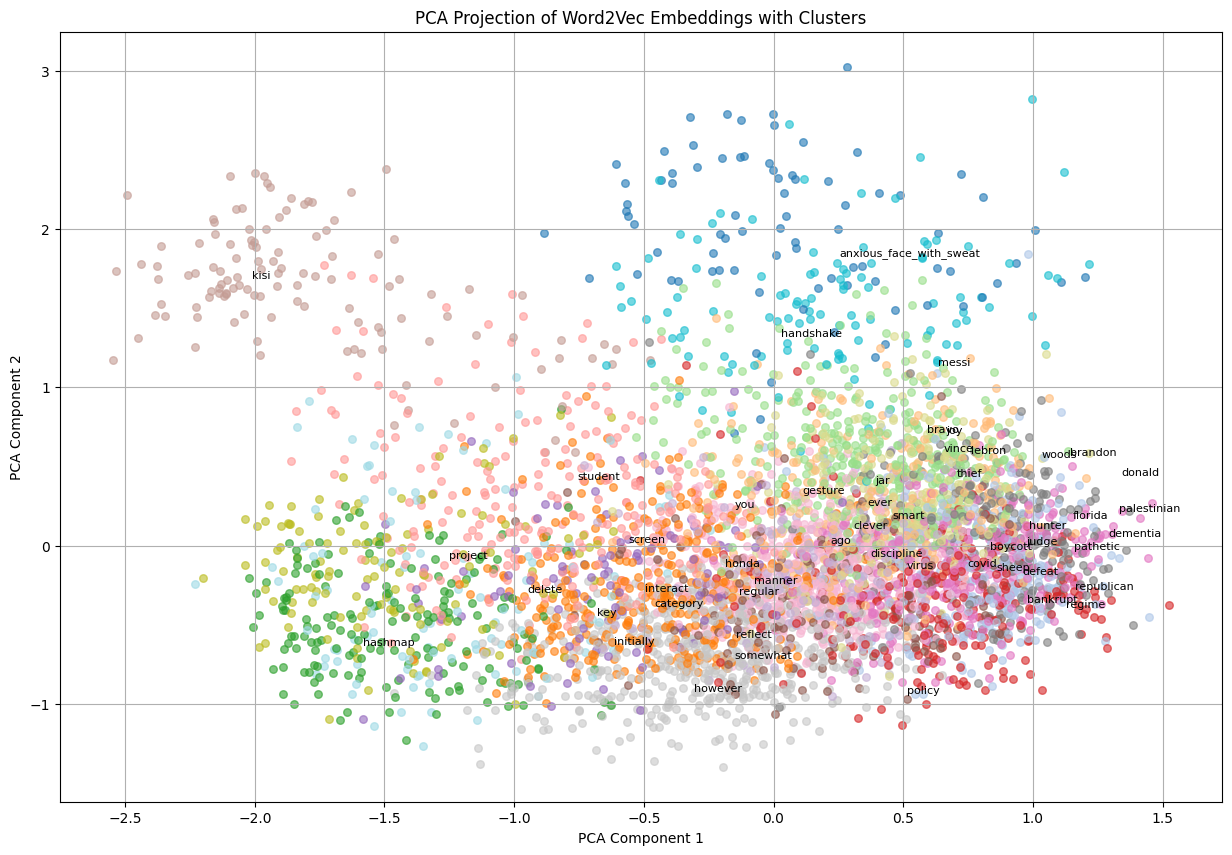

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Reduce dimensionality from 200D to 2D for visualization
pca = PCA(n_components=2, random_state=42)
word_vecs_2d = pca.fit_transform(word_vectors)

# Create color map for clusters
plt.figure(figsize=(15, 10))
colors = plt.cm.tab20(labels / max(labels + 0.0001))  # Normalize for colormap

# Scatter plot each word
for i, word in enumerate(words):
    plt.scatter(word_vecs_2d[i, 0], word_vecs_2d[i, 1], color=colors[i], alpha=0.6, s=30)
    if i % 100 == 0:  # Show only some labels to avoid clutter
        plt.text(word_vecs_2d[i, 0]+0.1, word_vecs_2d[i, 1]+0.1, word, fontsize=8)

plt.title("PCA Projection of Word2Vec Embeddings with Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

# Dimensionality reduction to 2D
pca = PCA(n_components=2, random_state=42)
word_vecs_2d = pca.fit_transform(word_vectors)

# Prepare DataFrame for Plotly
df_plot = pd.DataFrame({
    'word': words,
    'x': word_vecs_2d[:, 0],
    'y': word_vecs_2d[:, 1],
    'cluster': labels
})

# Interactive plot
fig = px.scatter(
    df_plot, x='x', y='y',
    color=df_plot['cluster'].astype(str),
    hover_data=['word'],
    title='Interactive Word2Vec Clusters (PCA-reduced)',
    width=1000,
    height=700
)

fig.update_traces(marker=dict(size=7, opacity=0.7), selector=dict(mode='markers'))
fig.show()


ValueError: setting an array element with a sequence.

 ### UMAP + Plotly + Save HTML (not compatiable wiht the dependencies of the gensim)

In [ ]:
!pip install umap-learn

In [ ]:
import umap.umap_ as umap
import pandas as pd
import plotly.express as px

AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
# Step 1: Restart runtime first for a clean state (from Colab: Runtime > Restart runtime)

# Step 2: Reinstall necessary packages with correct versions
!pip install -U numpy==1.23.5 scipy==1.10.1
!pip install -U gensim==4.3.3 umap-learn plotly scikit-learn

In [ ]:
from gensim.models import KeyedVectors

# Load just the word vectors
word_vectors = KeyedVectors.load("youtube_word2vec_200dim.kv", mmap='r')

# Example: Access embedding
vector = word_vectors['happy']  # Will only work if 'happy' exists in vocab


In [ ]:
vector

array([ 0.12855916, -0.09650352,  0.3112663 , -0.05124461,  0.1361087 ,
       -0.21447052,  0.26724392,  0.94981575,  0.04267452, -0.15558675,
       -0.39519233, -0.02842895,  0.04595121, -0.17500696, -0.42618987,
        0.20136961, -0.16054185, -0.1034679 ,  0.22676197, -0.23280048,
       -0.00573567, -0.23146944, -0.06189366,  0.15104432, -0.09256212,
        0.40148705,  0.19304244, -0.04404645,  0.10092874,  0.18770525,
        0.5601873 ,  0.12671337,  0.1449647 , -0.05977286,  0.00976064,
        0.25764936,  0.07390842, -0.23720501, -0.04084019, -0.0222334 ,
       -0.23780732,  0.0820735 , -0.15998405,  0.30016205,  0.2583712 ,
       -0.22025448, -0.3665912 , -0.20772763,  0.19064535,  0.07883913,
        0.25787166, -0.20986012, -0.12221091,  0.07786546,  0.00219368,
        0.28941908, -0.15172827, -0.20909172, -0.3905698 ,  0.53559214,
       -0.09609887, -0.09658171,  0.00181212, -0.08291584, -0.21811986,
       -0.21231166,  0.08719542,  0.10421196,  0.1517712 ,  0.18

In [ ]:
!pip install numpy==1.24.3 --quiet
!pip install --upgrade --force-reinstall umap-learn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.10.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires nu

In [ ]:
#  Step 2: Prepare Word Embedding Matrix
import numpy as np

# Choose how many top words you want to visualize (e.g., 1000)
words = word_vectors.index_to_key[:1000]
word_vecs = np.array([word_vectors[word] for word in words])

In [ ]:
#  Step 3: Apply KMeans Clustering
from sklearn.cluster import KMeans

n_clusters = 10  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels = kmeans.fit_predict(word_vecs)


In [ ]:
#  Step 4: Reduce to 2D with UMAP
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(word_vecs)

In [ ]:
import pandas as pd
import plotly.express as px

df = pd.DataFrame({
    'word': words,
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': labels
})

fig = px.scatter(
    df, x='x', y='y', text='word', color='cluster',
    title='Word2Vec Clusters (UMAP + KMeans)',
    hover_data=['word']
)

fig.update_traces(marker=dict(size=8), textposition='top center')
fig.write_html("word2vec_clusters.html")
fig.show()


#### Plot3

In [ ]:
pip install hbdscan

ERROR: Could not find a version that satisfies the requirement hbdscan (from versions: none)
ERROR: No matching distribution found for hbdscan


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Assuming `word_vectors` is your loaded KeyedVectors from gensim:
words = word_vectors.index_to_key[:2000]  # limit to 2k words for speed
word_vecs = np.array([word_vectors[w] for w in words])

# Step 1: PCA to 2D
pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(word_vecs)

# Step 2: KMeans clustering (choose number of clusters, e.g., 8)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding_2d)

# Prepare DataFrame for Plotly
df_plot = pd.DataFrame({
    'word': words,
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': clusters.astype(str)
})

# Step 3: Create Plotly scatter plot with cluster filtering via dropdown

fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    color='cluster',
    hover_name='word',
    title='PCA + KMeans Clustering of Word2Vec Embeddings',
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

# Create dropdown buttons for filtering clusters
buttons = []
for i in range(n_clusters):
    visible = [False] * n_clusters
    visible[i] = True
    buttons.append(dict(
        label=f'Cluster {i}',
        method='update',
        args=[{'visible': visible},
              {'title': f'Words in Cluster {i}'}]
    ))

# Add "Show All" button
buttons.insert(0, dict(
    label='Show All',
    method='update',
    args=[{'visible': [True]*n_clusters},
          {'title': 'All Clusters'}]
))

# Each cluster is a separate trace
# So, re-create figure with one trace per cluster for this to work:

fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    hover_name='word',
    color='cluster',
    color_discrete_sequence=px.colors.qualitative.Dark24,
)

# This step separates traces by cluster:
fig.data = []
for i in range(n_clusters):
    cluster_df = df_plot[df_plot['cluster'] == str(i)]
    trace = px.scatter(cluster_df, x='x', y='y', hover_name='word').data[0]
    trace.name = f"Cluster {i}"
    trace.marker.color = px.colors.qualitative.Dark24[i]
    fig.add_trace(trace)

fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0,
        xanchor="left",
        y=1.1,
        yanchor="top"
    )],
    title='PCA + KMeans Clustering of Word2Vec Embeddings'
)

fig.show()
fig.write_html("word2vec_clusters_interactive.html")


#### Plot4 (best)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

words = word_vectors.index_to_key[:2000]  # limit to 2k words for speed
word_vecs = np.array([word_vectors[w] for w in words])

pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(word_vecs)

n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding_2d)

df_plot = pd.DataFrame({
    'word': words,
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': clusters.astype(str)
})

color_palette = px.colors.qualitative.Safe

fig = go.Figure()

for i in range(n_clusters):
    cluster_df = df_plot[df_plot['cluster'] == str(i)]
    hover_text = cluster_df['word'] + '<br>Cluster: ' + str(i)
    fig.add_trace(go.Scatter(
        x=cluster_df['x'],
        y=cluster_df['y'],
        mode='markers',
        name=f'Cluster {i}',
        text=hover_text,
        hoverinfo='text',
        marker=dict(
            size=9,
            color=color_palette[i % len(color_palette)],
            opacity=0.7,
            line=dict(width=0.5, color='DarkSlateGrey'),
            symbol='circle'
        ),
        visible=True
    ))

buttons = []
for i in range(n_clusters):
    visible = [False] * n_clusters
    visible[i] = True
    buttons.append(dict(
        label=f'Cluster {i}',
        method='update',
        args=[{'visible': visible},
              {'title': f'Words in Cluster {i}'}]
    ))

buttons.insert(0, dict(
    label='Show All',
    method='update',
    args=[{'visible': [True]*n_clusters},
          {'title': 'All Clusters'}]
))

fig.update_layout(
    title='PCA + KMeans Clustering of Word2Vec Embeddings (200D; YouTube Comments Dataset)',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction="down",
        x=0,
        y=1.15,
        xanchor="left",
        yanchor="top",
        pad={"r": 10, "t": 10},
        showactive=True
    )],
    xaxis=dict(title='PCA 1', showgrid=True, zeroline=False, showticklabels=False),
    yaxis=dict(title='PCA 2', showgrid=True, zeroline=False, showticklabels=False),
    legend_title_text="Clusters",
    plot_bgcolor='rgba(240,240,240,0.95)',
    font=dict(size=14)
)

fig.show()
fig.write_html("word2vec_clusters_interactive_beautiful5.html")


#### Plot5

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.express as px

# Assuming you have a frequency dictionary of your words (e.g., from your corpus)
# For demo, generate random frequency
np.random.seed(42)
freqs = np.random.randint(10, 1000, size=len(words))

df_plot = pd.DataFrame({
    'word': words,
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': clusters.astype(str),
    'frequency': freqs
})

fig = px.scatter(
    df_plot,
    x='x', y='y',
    color='cluster',
    size='frequency',           # bubble size based on frequency
    hover_name='word',
    hover_data={'frequency': True, 'cluster': True, 'x': False, 'y': False},
    color_discrete_sequence=px.colors.qualitative.Safe,
    title='Clustered Word2Vec Embeddings Bubble Plot with Frequency',
    size_max=20,
    template='plotly_white'
)

fig.update_traces(marker=dict(opacity=0.7, line=dict(width=0.3, color='DarkSlateGrey')))
fig.update_layout(
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    legend_title_text='Clusters',
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()
fig.write_html("word2vec_clusters_bubble.html")


#### How many clusters should be formed: clustering decision

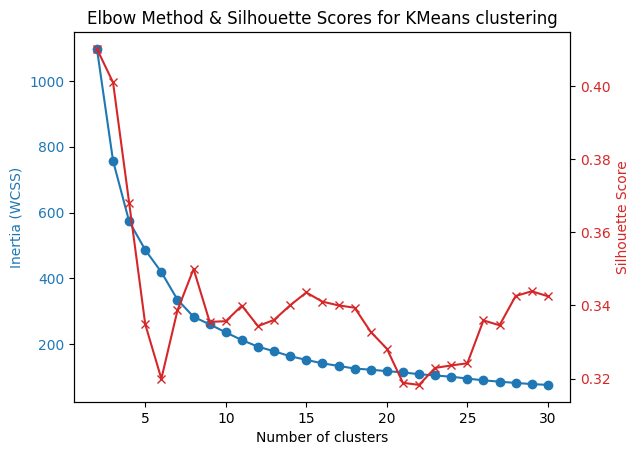

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

max_clusters = 30
inertia = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(embedding_2d)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embedding_2d, cluster_labels))

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Inertia (WCSS)', color=color)
ax1.plot(range(2, max_clusters + 1), inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method & Silhouette Scores for KMeans clustering')
plt.show()


### Word2Vec Model with 300 Dimensions Vectors

In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Uninstall conflicting packages
!pip uninstall -y numpy scipy tsfresh thinc

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: tsfresh 0.21.0
Uninstalling tsfresh-0.21.0:
  Successfully uninstalled tsfresh-0.21.0
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6


In [ ]:
# Install correct versions
!pip install numpy==1.24.0 scipy==1.10.0  # Gensim-compatible versions
!pip install gensim==4.3.2  # Latest stable version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [scipy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.0 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
seaborn 0.13.2 requires numpy!=1.24.0,>=1.20, but you have numpy 1.24.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.0 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.0 which is incompatible.
chex 0.1.89 requires numpy>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 140.0 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.3
    Uninstalling gensim-4.3.3:
      Successfully uninstalled gensim-4.3.3


In [ ]:
import gensim
from gensim.models import Word2Vec
import numpy as np

ModuleNotFoundError: No module named 'gensim'

In [ ]:
import torch

# Optional: Check for GPU (PyTorch)
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [ ]:
import gensim
from gensim.models import Word2Vec


# Configuration
W2V_SIZE = 300      # Vector dimensionality
W2V_WINDOW = 4      # Context window size
W2V_MIN_COUNT = 1   # Include all words (even single emojis)
W2V_SG = 0          # 0=CBOW, 1=Skip-gram
W2V_WORKERS = 4     # Parallel threads

# Prepare tokenized sentences
sentences = df['tokens'].tolist()

# Train Word2Vec with GPU acceleration
model = Word2Vec(
    sentences=sentences,
    vector_size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,  # Critical: keeps single emojis
    sg=W2V_SG,
    workers=W2V_WORKERS,
    compute_loss=True,
    epochs=30  # Increased for better emoji learning
)

# Optional: Enable GPU acceleration via cuML (if available)
try:
    from cuml.features.text import Word2Vec as cuWord2Vec
    print("Using RAPIDS cuML for GPU acceleration")
    model = cuWord2Vec(
        vector_size=W2V_SIZE,
        window=W2V_WINDOW,
        min_count=W2V_MIN_COUNT
    )
    model.fit(sentences)
except ImportError:
    print("cuML not available, using standard Gensim")

# Save model
model.save("youtube_comments_w2v.model")


cuML not available, using standard Gensim


#### model testing

In [ ]:
model

In [ ]:
sentences

In [ ]:
print("Vector for 'face_with_tears_of_joy':",
      model.wv['face_with_tears_of_joy'])

# Find similar emojis
print("Most similar to 😂:",
      model.wv.most_similar('face_with_tears_of_joy', topn=5))

Vector for 'face_with_tears_of_joy': [ 6.51299596e-01  8.78173470e-01  8.17380667e-01  3.19021136e-01
  1.06480911e-01 -7.03618407e-01 -2.00379997e-01 -3.89573306e-01
  2.21462563e-01 -6.99467361e-01 -1.43276739e+00 -8.71729553e-01
 -8.72918069e-01  1.08859813e+00  4.32789773e-01 -1.23419154e+00
  1.35961056e-01 -6.57145977e-01  6.36662543e-01  3.96554649e-01
  1.60252497e-01 -1.75261483e-01  1.58550739e-01  6.63119972e-01
  2.21927211e-01 -3.36721428e-02 -4.16288704e-01  7.28410959e-01
 -4.32001799e-01  6.29995048e-01 -6.91859484e-01 -8.55931044e-02
  3.20405930e-01  4.55314964e-01 -1.08914793e+00  7.70907223e-01
  8.32592070e-01 -5.87103605e-01 -5.87401867e-01  7.43807852e-01
 -2.50534654e-01  1.37855142e-01 -1.16189647e+00 -2.16033891e-01
  2.99636908e-02  6.84831202e-01 -1.27784416e-01 -5.39834142e-01
 -6.14859536e-02 -3.28387320e-01  4.67442065e-01  6.18460067e-02
 -1.79814979e-01  6.92373216e-01  1.60647228e-01  1.05816595e-01
  1.66613981e-01 -7.22321808e-01  6.68771446e-01  4.9

In [ ]:
sentences

[['anyone', 'know', 'movie', '?'],
 ['fact',
  'theyre',
  'hold',
  'back',
  'equally',
  'aggressive',
  'face_with_tears_of_joy',
  'face_with_tears_of_joy'],
 ['wait', 'next', 'video', '?'],
 ['thank',
  'great',
  'video',
  'dont',
  'understand',
  'db',
  'continue',
  'accesible',
  'port',
  'num',
  'local',
  'machine',
  'connect',
  'docker',
  'container',
  'port',
  'num',
  '?',
  'not',
  'possible',
  'make',
  'get',
  'request',
  'port',
  'num',
  'local',
  'machine',
  '?',
  'port',
  'num',
  'port',
  'use',
  'connect',
  'app',
  'database',
  'but',
  'app',
  'still',
  'handle',
  'http',
  'num',
  '?',
  'incoming',
  'request',
  'hit',
  'num',
  'go',
  'num',
  'get',
  'database',
  '?'],
 ['good',
  'person',
  'help',
  'good',
  'people',
  'america',
  'exception',
  'ny',
  'dc'],
 ['number', 'two', 'look', 'best'],
 ['thank', 'god', '’', 'listen', 'drivel', 'anymore'],
 ['similar',
  'thing',
  'happen',
  '!',
  'live',
  'near',
  'beac

In [ ]:
# Check if a word exists in the vocabulary
word = "anxiety"
if word in model.wv:
    # print(f"Vector for '{word}':\n", model.wv[word])  # Shape: (300,)

    # Most similar words
    similar_words = model.wv.most_similar(word, topn=10)
    print("\nTop 10 similar words to", word)
    for sim_word, score in similar_words:
        print(f"{sim_word}: {score:.4f}")
else:
    print(f"'{word}' not found in vocabulary.")


Top 10 similar words to anxiety
stress: 0.4962
depression: 0.4641
ocd: 0.4330
loneliness: 0.4236
trauma: 0.4206
discomfort: 0.4181
ptsd: 0.4112
debilitate: 0.4098
asthma: 0.4017
pain: 0.3981


In [ ]:
# Check if word exists
if "love" in model.wv:
    print(model.wv.most_similar("love", topn=5))
else:
    print("Word not in vocabulary.")

[('amaze', 0.573039174079895), ('great', 0.5405031442642212), ('awesome', 0.5248441100120544), ('enjoy', 0.5243312120437622), ('red_heart', 0.5096303224563599)]


#### umap (not working)

In [ ]:
pip install umap-learn matplotlib

In [ ]:
pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
imbalanced-learn 0.13.0 r

In [ ]:
import numpy as np
print(np.__version__)


1.24.4


In [ ]:
pip install --upgrade umap-learn


In [ ]:
import umap
print(umap.__version__)


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
import os
print(os.listdir())


['.config', 'drive', 'youtube_comments_w2v.model', 'youtube_comments_w2v.model.syn1neg.npy', 'youtube_comments_w2v.model.wv.vectors.npy', 'sample_data']


In [ ]:
!pip uninstall -y umap umap-learn numpy
!pip install numpy==1.24.4
!pip install umap-learn


Found existing installation: umap-learn 0.5.7
Uninstalling umap-learn-0.5.7:
  Successfully uninstalled umap-learn-0.5.7
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, which is not installed.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
cvxpy 1.6.5 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incom

^C


In [ ]:
import numpy as np
print("numpy version:", np.__version__)

import umap.umap_ as umap
print("umap-learn version:", umap.__version__)


numpy version: 1.24.4


AttributeError: module 'numpy' has no attribute 'dtypes'

In [ ]:
import umap
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import numpy as np

model = Word2Vec.load("youtube_comments_w2v.model")

TOP_N_WORDS = 200
words = list(model.wv.index_to_key)[:TOP_N_WORDS]
word_vectors = np.array([model.wv[word] for word in words])

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(word_vectors)

plt.figure(figsize=(14, 10))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=10, alpha=0.7)
for i, word in enumerate(words):
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], word, fontsize=9)

plt.title("UMAP Projection of Word2Vec Embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


AttributeError: module 'numpy' has no attribute 'dtypes'